Ref: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [1]:
cd ..

/Users/nicolas.peruchot/workdir/peafowl


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datasets import load_dataset
from peafowl.preprocessing.utils import lemmatizer_dataset
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

torch.manual_seed(1)

In [3]:
data_tot = load_dataset('amazon_reviews_multi','en')['train']
data=data_tot['review_body']
stars=data_tot['stars']

data=pd.Series([e for i,e in enumerate(data) if i<1000 or i>198999])
stars=pd.Series([e for i,e in enumerate(stars) if i<1000 or i>198999])
data=lemmatizer_dataset(data)

Reusing dataset amazon_reviews_multi (/Users/nicolas.peruchot/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
100%|██████████| 3/3 [00:00<00:00, 202.81it/s]


In [4]:
CONTEXT_SIZE = 4
EMBEDDING_DIM = 300

ngrams = [
    (
        [sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        sentence[i]
    ) for sentence in data
    for i in range(CONTEXT_SIZE, len(sentence))
]


vocab = set([word for sentence in data for word in sentence ])
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {v:k for k,v in word_to_ix.items()}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(35):
    total_loss = 0
    for context, target in ngrams:

        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        model.zero_grad()

        log_probs = model(context_idxs)

        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)



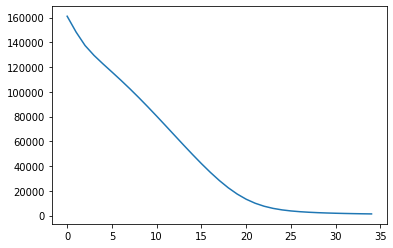

In [5]:
plt.plot(losses)

In [6]:
X=model.embeddings.weight.detach().numpy()

In [7]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(X=X)

NearestNeighbors(n_neighbors=10)

In [8]:
for x in neigh.kneighbors(X[word_to_ix["good"]].reshape(1,-1))[1][0]:
    print(ix_to_word[x])

good
bulb
bottle
Dad
pen
supplemental
spin
gardening
packed
someday
